**4. Bank Marketing**
---


In [1]:
### Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

### Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


#### Datasets, Metrics and Preprocessing

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.utils.multiclass import unique_labels

In [2]:
# import classiy function from the 'main_functions' notebook
from ipynb.fs.defs.main_functions import classify

In [3]:
# Defining the classifier that can be used with easy calling names
classifiers = {'Naive Bayes': GaussianNB, 'KNN': KNeighborsClassifier, 'Logistic Regression': LogisticRegression,\
              'RF': RandomForestClassifier, 'SVM': SVC, 'SGD': SGDClassifier, 'AdaBoost': AdaBoostClassifier}

In [6]:
# Reading the dataset and creating the dataframe
cancer_diag = pd.read_csv('bank-full.csv',sep=';')

df = cancer_diag

In [6]:
import sklearn
sklearn.__version__

'0.21.2'

# Exploratory Data Analysis (EDA)
This step is to get to know the data and decide what type of preprocessing needs to be done before training the model

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027337F80320>,
      dtype=object)

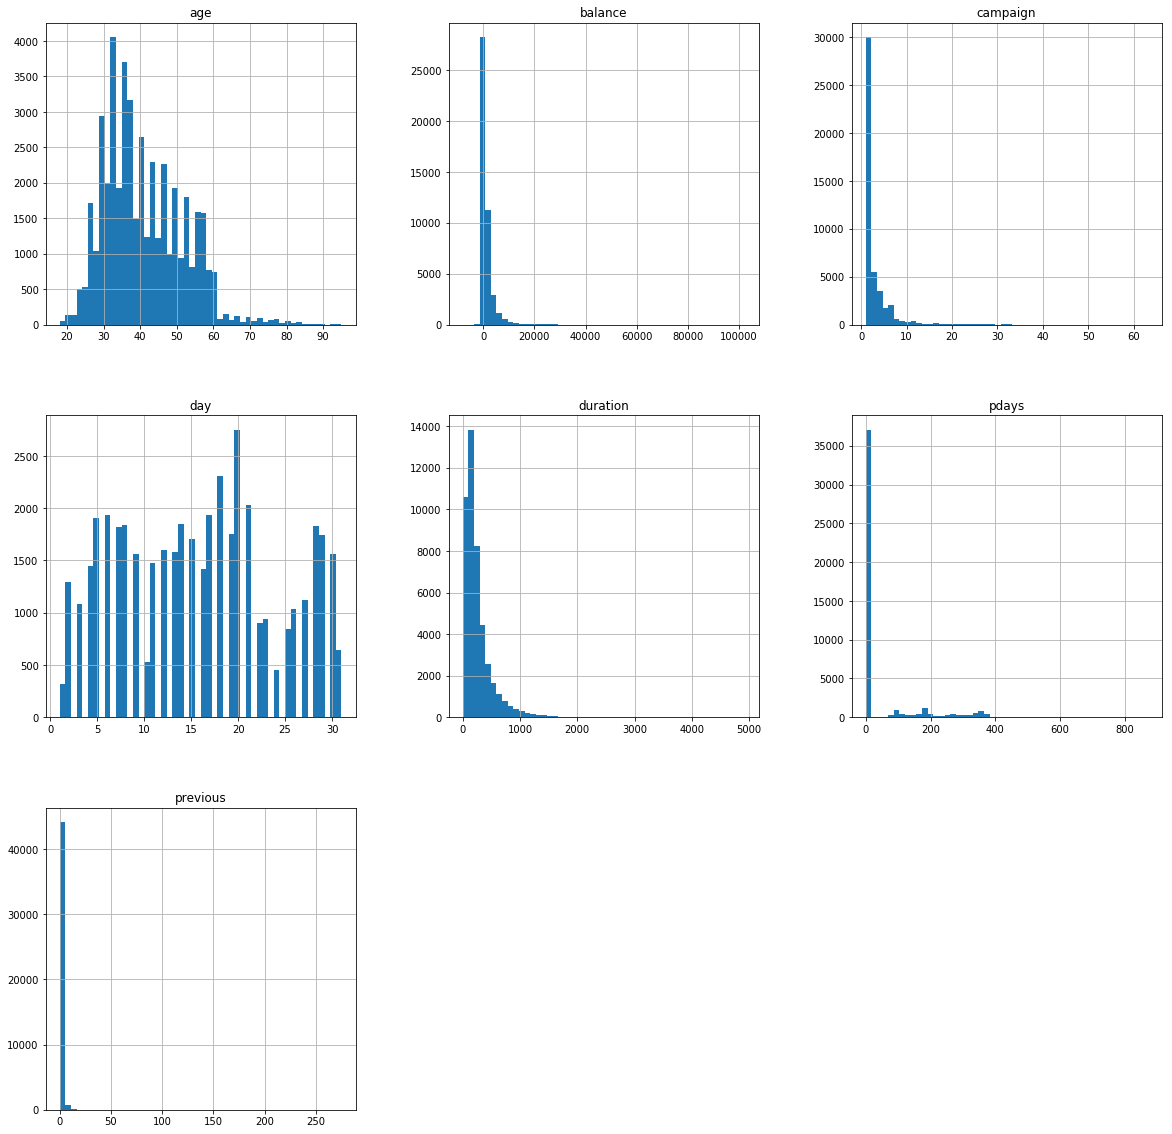

In [12]:
df.hist(bins=50,figsize=(20,20))


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


ValueError: range parameter must be finite.

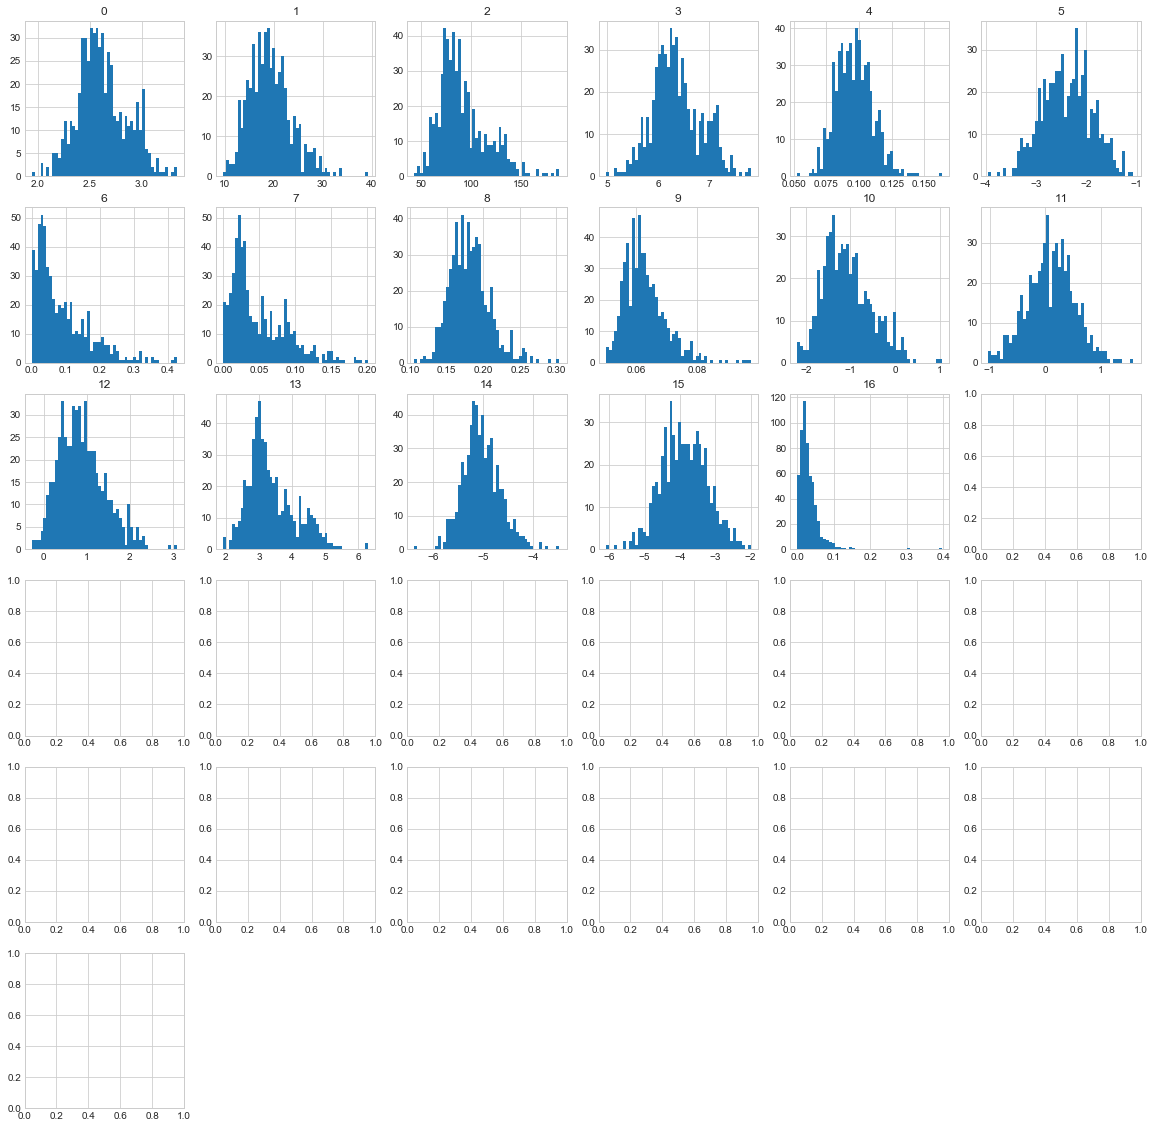

In [54]:
df_new = df.copy()
df_new = df_new.apply(lambda x: np.log(x) if x.name in [0,3,5,10,11,12,13,14,15,17,18,19,20,22,23,25,26] else x)
df_new.hist(bins=50,figsize=(20,20))
plt.show()

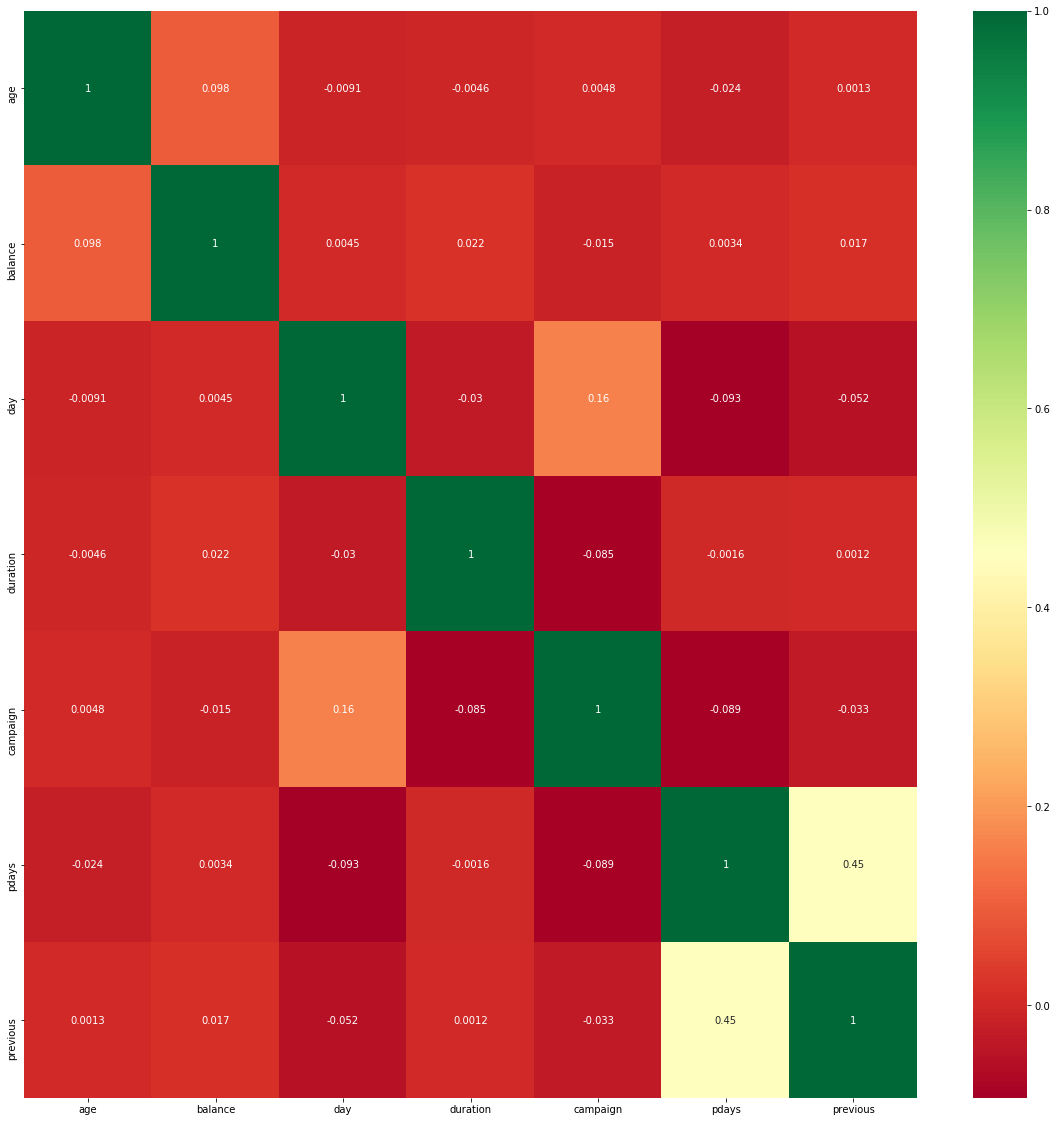

In [14]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
# top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True,cmap="RdYlGn")

In [15]:
corrmat['y'].sort_values(ascending=True)

KeyError: 'y'

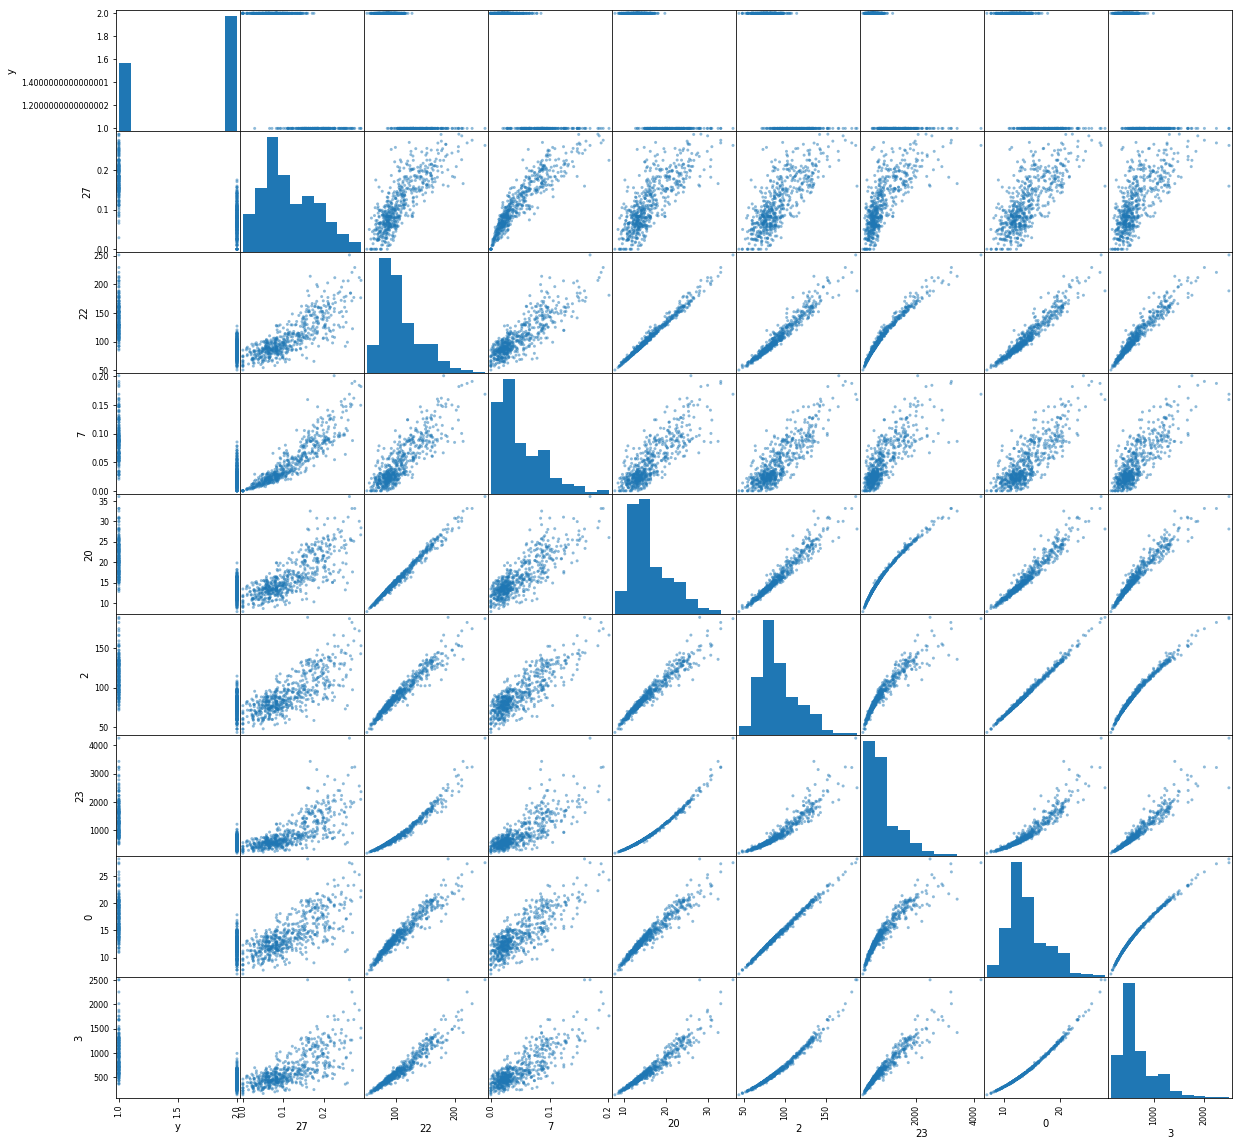

In [10]:
imp_attribs = pd.plotting.scatter_matrix(df[['y',27,22, 7,20,2,23,0,3]], figsize=(20,20))

In [16]:
df['y'].value_counts()
df['y'].value_counts()/df['y'].value_counts().sum()
# print(ratio)

no     0.883015
yes    0.116985
Name: y, dtype: float64

In [12]:
# sns.set_style('whitegrid')
balance_check = sns.countplot(x='y',data=df,palette='RdBu_r')

NameError: name 'sns' is not defined

# Preprocessing

**In this dataset:** <br>
- categorical attributes exists (job,marital,education,default,housing,loan,month,contact,poutcome,y)<br>
    - please note that month can be numeric integer values not categorical to show ordinal type
- It is considered imbalanced since the ratio is almost 1:9 (no, yes)
- Dummy variable for categorical and Scaling for numeric data will be applied

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [52]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer

In [53]:
# The describe method gets the numeric features only
num_features = list(df.describe())

# this line gets the rest of the deatures and considers them categorical, 
# it need to be implemented with caution after doing the EDA
cat_features = [f for f in list(df.keys()) if f not in num_features]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('std_scalar', StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [60]:
bank_prepared = cat_pipeline.fit_transform(df[cat_features])

TypeError: fit_transform() takes 2 positional arguments but 3 were given

# 1. Naive Bayes

The model score is 0.935 (+/- 0.023)
The IQR is 0.020 between [0.93,0.95]
There is 0 deleted rows


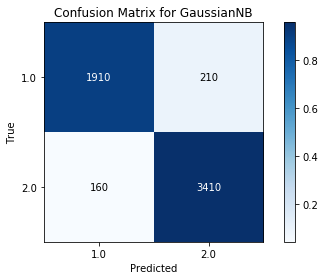

In [22]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['Naive Bayes']())

The model score is 0.932 (+/- 0.033)
The IQR is 0.070 between [0.89,0.96]
There is 0 deleted rows


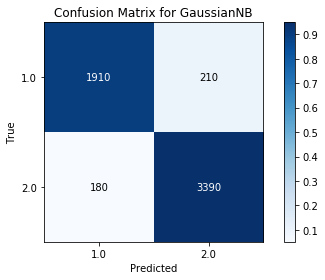

In [25]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['Naive Bayes']())

# 2. Logistic Regression

The model score is 0.951 (+/- 0.019)
The IQR is 0.018 between [0.95,0.96]
There is 0 deleted rows


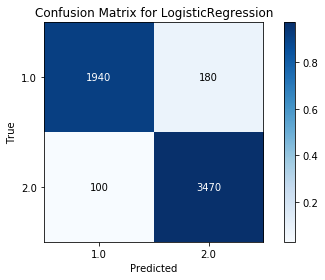

In [26]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['Logistic Regression']())

The model score is 0.982 (+/- 0.014)
The IQR is 0.000 between [0.98,0.98]
There is 0 deleted rows


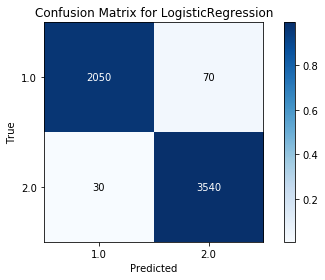

In [31]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['Logistic Regression']())

# 3. Ensemble - Random Forests

The model score is 0.964 (+/- 0.030)
The IQR is 0.035 between [0.95,0.98]
There is 0 deleted rows


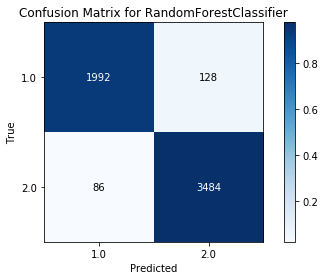

In [35]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['RF'](n_estimators = 100))

The model score is 0.962 (+/- 0.030)
The IQR is 0.035 between [0.95,0.98]
There is 0 deleted rows


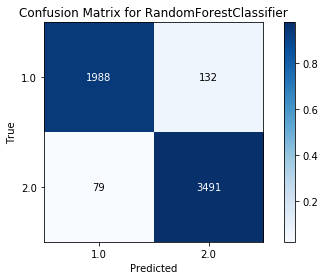

In [39]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['RF'](n_estimators=100))

# 4. Ensemble - AdaBoost

The model score is 0.976 (+/- 0.013)
The IQR is 0.017 between [0.97,0.98]
There is 0 deleted rows


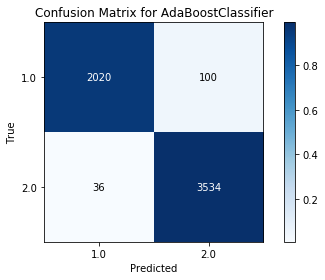

In [41]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['AdaBoost'](n_estimators=100))

# 5. K-Nearest Neighbours

The model score is 0.930 (+/- 0.029)
The IQR is 0.054 between [0.91,0.96]
There is 0 deleted rows


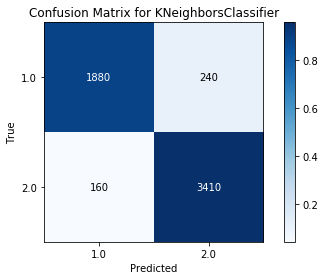

In [45]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['KNN'](5))

The model score is 0.967 (+/- 0.020)
The IQR is 0.035 between [0.95,0.98]
There is 0 deleted rows


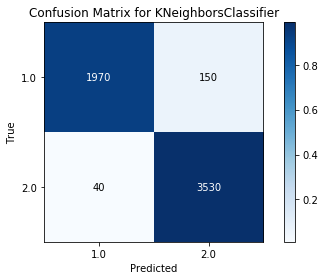

In [47]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['KNN'](5))

# 6. Support Vector Machines - Linear Kernel

The model score is 0.954 (+/- 0.019)
The IQR is 0.034 between [0.93,0.96]
There is 0 deleted rows


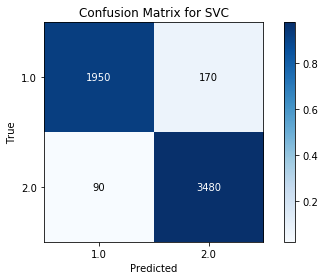

In [24]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['SVM'](kernel='linear'))

The model score is 0.977 (+/- 0.024)
The IQR is 0.036 between [0.96,1.00]
There is 0 deleted rows


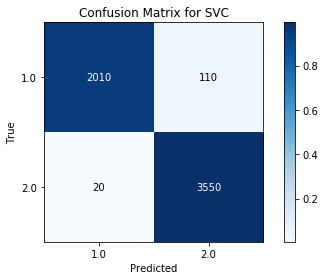

In [25]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['SVM'](kernel='linear'))

# 7. Support Vector Machines - RBF Kernel

The model score is 0.916 (+/- 0.029)
The IQR is 0.033 between [0.90,0.93]
There is 0 deleted rows


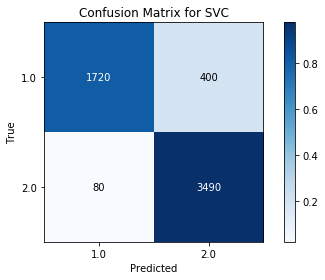

In [26]:
conf, test_scores = classify(df.drop('y',axis=1), df['y'],classifiers['SVM'](kernel='rbf', gamma='scale'))

The model score is 0.984 (+/- 0.015)
The IQR is 0.018 between [0.98,1.00]
There is 0 deleted rows


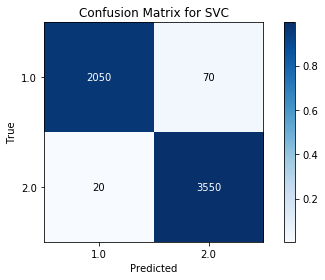

In [30]:
conf, test_scores = classify(cancer_prepared, df['y'],classifiers['SVM'](kernel='rbf', gamma='scale', C=10))

In [14]:
1/(cancer_prepared.shape[1]*cancer_prepared.var())

0.03333333333333333

30

In [38]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl